## CV10 - CAM을 만들고 평가해보자
### CAM 구현하기

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *

import numpy as np
import os
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
import urllib3
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'cars196',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

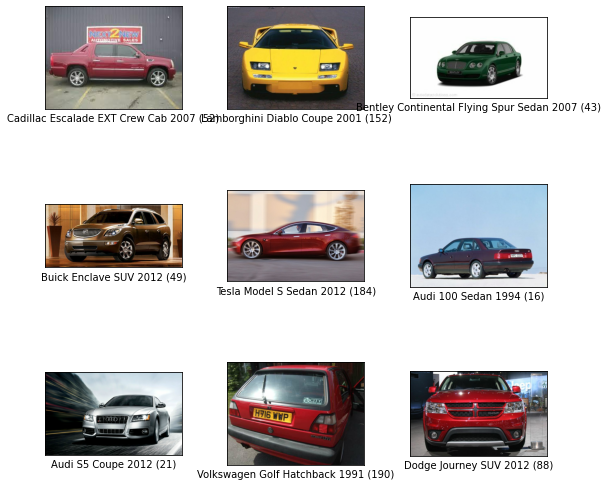

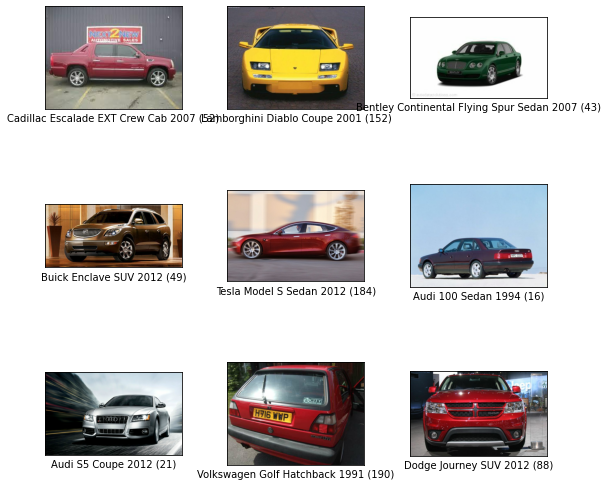

In [4]:
tfds.show_examples(ds_train, ds_info)

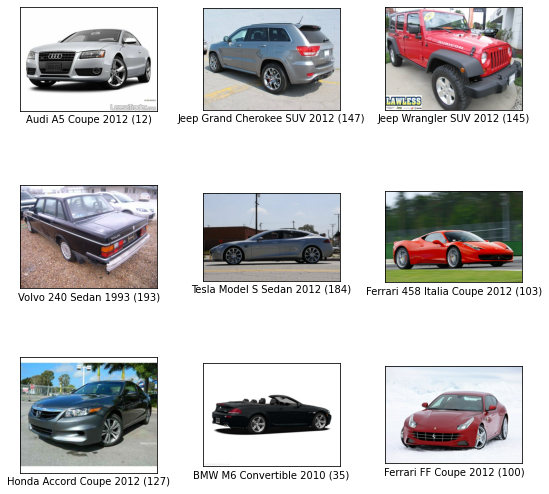

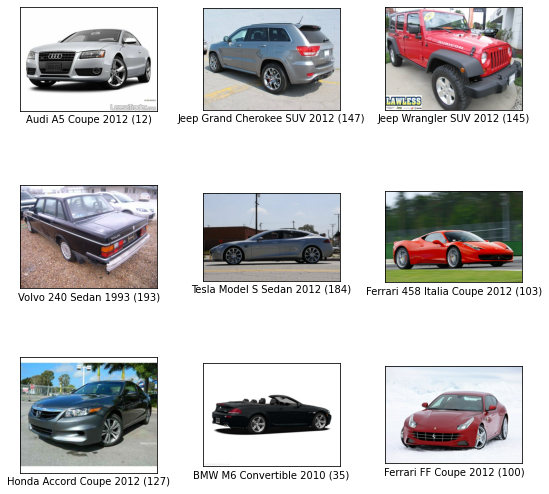

In [5]:
tfds.show_examples(ds_test, ds_info)

In [6]:
ds_info.features

FeaturesDict({
    'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=196),
})

In [7]:
num_classes = ds_info.features['label'].num_classes

base_model = keras.applications.resnet.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(224,224,3),
    pooling='avg')

x = base_model.output
preds = Dense(num_classes, activation='softmax')(x)
cam_model = keras.Model(inputs=base_model.input, outputs=preds)

In [8]:
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [9]:
def normalize_and_resize_img(input):
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(normalize_and_resize_img, num_parallel_calls=2)
    ds = ds.batch(batch_size)
    
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [10]:
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_test_norm = apply_normalize_on_dataset(ds_test)

In [11]:
tf.random.set_seed(2020)
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy']
)

In [12]:
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=15,
    validation_data=ds_test_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
509/509 [==============================] - 81s 159ms/step - loss: 4.1410 - accuracy: 0.1655 - val_loss: 5.4369 - val_accuracy: 0.0055
Epoch 2/15
509/509 [==============================] - 80s 157ms/step - loss: 1.6297 - accuracy: 0.6428 - val_loss: 1.9873 - val_accuracy: 0.4963
Epoch 3/15
509/509 [==============================] - 81s 158ms/step - loss: 0.6076 - accuracy: 0.8912 - val_loss: 1.3040 - val_accuracy: 0.6582
Epoch 4/15
509/509 [==============================] - 112s 221ms/step - loss: 0.1808 - accuracy: 0.9818 - val_loss: 1.1593 - val_accuracy: 0.7002
Epoch 5/15
509/509 [==============================] - 80s 158ms/step - loss: 0.0732 - accuracy: 0.9957 - val_loss: 1.0566 - val_accuracy: 0.7252
Epoch 6/15
509/509 [==============================] - 80s 158ms/step - loss: 0.0410 - accuracy: 0.9980 - val_loss: 1.0373 - val_accuracy: 0.7297
Epoch 7/15
509/509 [==============================] - 81s 158ms/step - loss: 0.0298 - accuracy: 0.9980 - val_loss: 1.0451 - val_a

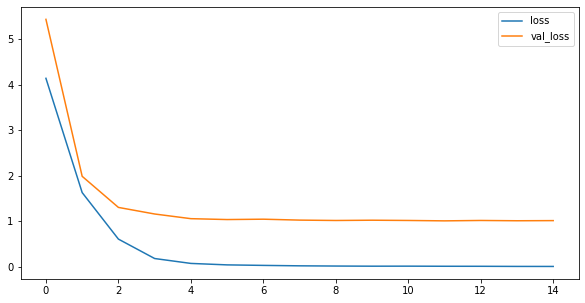

In [13]:
plt.figure(figsize=(10,5))
plt.plot(history_cam_model.history['loss'], label='loss')
plt.plot(history_cam_model.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [14]:
# cam_model_path = os.getenv('HOME') + '/aiffel/class_activation_map/cam_model2.h5'
# cam_model.save(cam_model_path)

In [15]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

87


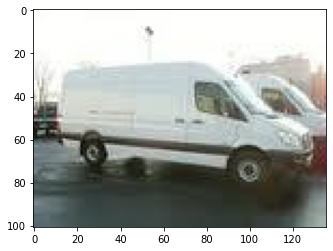

In [16]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

In [17]:
cam_model_path = os.getenv('HOME') + '/aiffel/class_activation_map/cam_model2.h5'
cam_model = tf.keras.models.load_model(cam_model_path)

In [18]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # GAP 적용되기 전의 레이어를 가져온다. 특성맵 구하기
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    
    conv_outputs = conv_outputs[0, :, :, :]
    class_weights = model.layers[-1].get_weights()[0]
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    # 클래스별 확률을 얻기 위한 소프트맥스 레이어의 가중치
    for i, w in enumerate(class_weights[:, class_idx]):
        cam_image += w * conv_outputs[:, :, i]
        
    cam_image /= np.max(cam_image)
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height))
    return cam_image

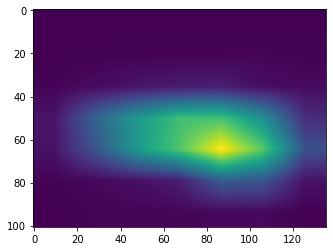

In [19]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

In [20]:
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

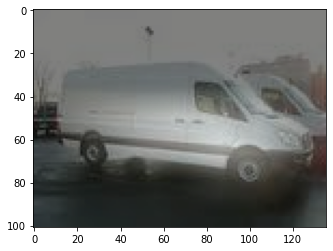

In [21]:
origin_image = item['image'].astype(np.uint8)
cam_image_3ch = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3ch, origin_image)
plt.imshow(blended_image)
plt.show()

### Grad-CAM

In [22]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] 
        output = conv_output[0] 
        grad_val = tape.gradient(loss, conv_output)[0] 

    weights = np.mean(grad_val, axis=(0, 1)) 
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    # 클래스별 가중치
    for k, w in enumerate(weights):
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

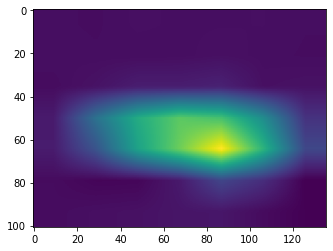

In [23]:
grad_cam_image5 = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image5)
plt.show()

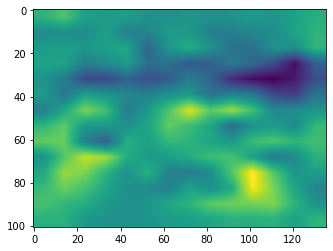

In [24]:
grad_cam_image4 = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image4)
plt.show()

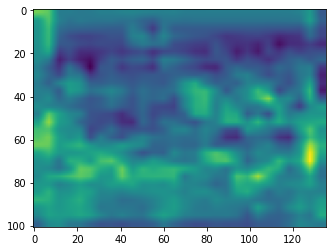

In [25]:
grad_cam_image3 = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image3)
plt.show()

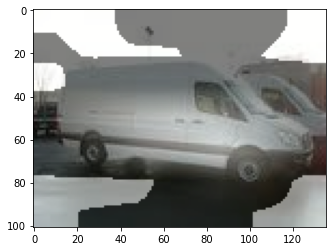

In [26]:
origin_image = item['image'].astype(np.uint8)
grad_cam_image5_3ch = np.stack([grad_cam_image5*255]*3, axis=-1).astype(np.uint8)

blended_image5 = visualize_cam_on_image(grad_cam_image5_3ch, origin_image)
plt.imshow(blended_image5)
plt.show()

### 바운딩 박스 구하기

In [27]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

In [28]:
image = copy.deepcopy(item['image'])
cam_rect = get_bbox(cam_image)
cam_rect

array([[135,  91],
       [  0,  91],
       [  0,  30],
       [135,  30]])

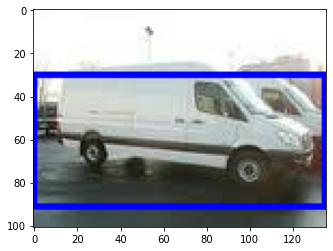

In [29]:
image = cv2.drawContours(image, [cam_rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

In [30]:
image = copy.deepcopy(item['image'])
grad_rect = get_bbox(grad_cam_image5)
grad_rect

array([[135,  90],
       [ 11,  90],
       [ 11,  35],
       [135,  35]])

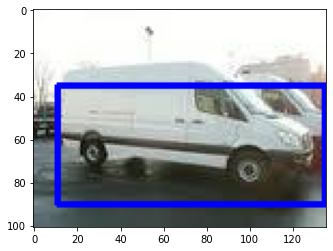

In [31]:
image = cv2.drawContours(image, [grad_rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

### IoU 구하기

In [32]:
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]),  #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1])   #bounding box의 x_max
    ]
    return bbox

In [33]:
cam_pred_bbox = rect_to_minmax(cam_rect, item['image'])
cam_pred_bbox

[0.297029702970297, 0.0, 0.900990099009901, 0.9926470588235294]

In [34]:
grad_pred_bbox = rect_to_minmax(grad_rect, item['image'])
grad_pred_bbox

[0.3465346534653465,
 0.08088235294117647,
 0.8910891089108911,
 0.9926470588235294]

In [35]:
item['bbox']

array([0.21782178, 0.08088236, 0.8613861 , 0.97794116], dtype=float32)

In [36]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

In [37]:
# CAM IoU

get_iou(cam_pred_bbox, item['bbox'])

0.7549668460109499

In [38]:
# Grad-CAM IoU

get_iou(grad_pred_bbox, item['bbox'])

0.7546989846032519

CAM과 Grad-CAM의 IoU성능이 비슷하게 나온다.  